In [1]:
from sklearn.linear_model import LinearRegression
import colour, pickle, pandas, os, sys
from scipy.stats.mstats import zscore
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from IPython.display import Markdown as md
from scipy import stats
import warnings ; warnings.filterwarnings('ignore')

In [2]:
# get parent directory containing all data 
base_directory = os.path.abspath('..')

# append to path to incorporate custom functions 
sys.path.append(base_directory) 

# import custom visualization functions for figures
import visualization_functions as viz

# import custom functions for analyzing the retrospective dataset
import retrospective.combine_results as retrospective_analyses

# set location to save figures to 
figure_location = os.path.join(base_directory, 'summary/manuscript/figures/') 

# set location of retrospective datasets and results 
retrospective_directory = os.path.join(base_directory, 'retrospective')

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Methods: Model Fit to Electrophysiological Data

In [4]:
# location of electrophysiological neural data from IT and V4 
electrophysiological_location = os.path.join(base_directory, 'electrophysiological/')

with open(os.path.join(electrophysiological_location, 'reliability_and_fitting_results.pickle'), 'rb') as f: 
    pls_fits = pickle.load(f)
    fit_layers = len(pls_fits['it']['mu'])

## median split-half reliability for IT

In [5]:
md(r'$r=%.02f \pm %.02fSTD$'%(np.median(pls_fits['it_splithalf_r']), np.std(pls_fits['it_splithalf_r'])))

$r=0.73 \pm 0.24STD$

## median split-half reliability for V4

In [6]:
md(r'$r=%.02f \pm %.02fSTD$'%(np.median(pls_fits['v4_splithalf_r']), np.std(pls_fits['v4_splithalf_r'])))

$r=0.62 \pm 0.22STD$

### first half of model fits V4 better

In [7]:
v4_firsthalf = stats.ttest_ind(pls_fits['v4']['mu'][:fit_layers//2], pls_fits['v4']['mu'][fit_layers//2:]) 

md(r'$ t( %d )=%.02f, P = %.03f$'%(((fit_layers-1)//2), v4_firsthalf[0],  v4_firsthalf[1]))

$ t( 9 )=2.70, P = 0.015$

### second half fits IT better

In [8]:
it_secondhalf = stats.ttest_ind(pls_fits['it']['mu'][fit_layers//2:], pls_fits['it']['mu'][:fit_layers//2]) 

md(r'$ t(%d)=%.02f, P = %.03f$'%(((fit_layers-1)//2), it_secondhalf[0], it_secondhalf[1]))

$ t(9)=3.70, P = 0.002$

### Differential model fit to IT cortex increases with layer depth

In [9]:
viz.show_model_parameters(smf.ols('zscore(y)~zscore(x)',{'y':pls_fits['delta'],'x':np.arange(fit_layers)}))

$\beta = 0.98$, $F(1, 17)$ = $20.91, P = 1 $ x $ 10 ^{-13} $

## Identify 'IT-like' and 'V4-like' layers used in the retrospective dataset

In [10]:
# identify layer with the highest fit to it cortex 
it_layer = pls_fits['layers'][ pls_fits['it']['mu'].argmax() ] 

# identify layer with the highest fit to v4 cortex 
v4_layer =  pls_fits['layers'][ pls_fits['v4']['mu'].argmax() ] 

# Results 2.1: Retrospective Analysis

In [11]:
# load retrospective results -- model performance and human performance across all eligible stimuli  
retrospective = retrospective_analyses.integrate_across_studies(retrospective_directory, it_layer, v4_layer )

# compute summary statistics across retrospective results 
retrospective, meta_statistics = retrospective_analyses.summary_statistics(retrospective, it_layer, v4_layer)

# human performance for mis-classified stimuli
misclassified = retrospective_analyses.misclassified_experiments(retrospective_directory) 

In [12]:
n_experiments = len(retrospective[it_layer])

## 2.1.1 Multiple stimulus sets have been misclassied on both side of the debate

In [13]:
misclassified[['model_performance', 'study', 'experiment', 'PRC involved in perception?']]

,model_performance,study,experiment,PRC involved in perception?
0,1,Barense et al. 2007,Fribbels Low Ambiguity,"Claim: ""Yes"""
1,1,Barense et al. 2007,Fribbles Medium Ambiguity,"Claim: ""Yes"""
2,1,Barense et al. 2007,Fribbles High Ambiguity,"Claim: ""Yes"""
3,1,Inhoff et al. 2018,Oddity Low Difficulty,"Claim: ""Yes"""
4,1,Inhoff et al. 2018,Oddity Medium Difficulty,"Claim: ""Yes"""
5,1,Inhoff et al. 2018,Oddity High Difficulty,"Claim: ""Yes"""
6,1,Knutson et al. 2011,Difficulty level 1,"Claim: ""No"""
7,1,Knutson et al. 2011,Difficulty level 2,"Claim: ""No"""
8,1,Knutson et al. 2011,Difficulty level 3,"Claim: ""No"""
9,1,Knutson et al. 2011,Difficulty level 4,"Claim: ""No"""


## 2.1.2 PRC-lesioned subjects are impaired on concurrent visual discrimination tasks

In [14]:
# test for significant difference between prc-lesioned and -intact subjects on elegable stimuli
viz.show_model_parameters(smf.ols(formula='prc_delta~1', data=retrospective))

$\beta = 0.14$, $F(0, 13)$ = $2.68, P = 0.019 $

### Not a significant difference between HPC-lesioned and HPC-intact subjects

In [15]:
# test for significant difference between hpc-lesioned and -intact subjects on elegable stimuli
viz.show_model_parameters( smf.ols(formula='hpc_delta~1', data=retrospective))

$\beta = 0.01$, $F(0, 13)$ = $0.73, P = 0.479 $

### There is a significant difference between the _difference_ between groups

In [16]:
viz.show_model_parameters(smf.ols('delta~group',
      {'delta': np.concatenate([retrospective['hpc_delta'], retrospective['prc_delta']]), 
       'group': np.concatenate([np.repeat('hpc', n_experiments), np.repeat('prc', n_experiments)])}))

$\beta = 0.13$, $F(1, 26)$ = $2.34, P = 0.028 $

## 2.1.3 A computational model of the VVS approximates PRC-lesioned performance

In [17]:
viz.show_model_parameters(smf.ols("zscore(prc_lesion) ~ zscore(%s)"%it_layer, retrospective))

$\beta = 0.85$, $F(1, 12)$ = $5.59, P = 1 $ x $ 10 ^{-4} $

### A computational model of the VVS does not predict the behavior of PRC-intact subjects

In [18]:
viz.show_model_parameters(smf.ols("zscore(prc_intact) ~ zscore(%s)"%it_layer, retrospective))

$\beta = 0.51$, $F(1, 12)$ = $2.05, P = 0.063 $

### PRC-intact subjects significantly outperform this computational proxy for the VVS 

In [19]:
viz.show_model_parameters(smf.ols('delta ~ 1', 
                                 {'delta': retrospective['prc_intact']-retrospective[it_layer]}))

$\beta = 0.35$, $F(0, 13)$ = $7.32, P = 6 $ x $ 10 ^{-6} $

In [20]:
viz.show_model_parameters(smf.ols("zscore(hpc_lesion) ~ zscore(%s)"%it_layer, retrospective))

$\beta = 0.55$, $F(1, 12)$ = $2.28, P = 0.042 $

### Critically, there is a significant interaction between PRC-intact and -lesioned subjects

In [21]:
viz.show_model_parameters(smf.ols("human ~ model * group", data = {
    'model': np.concatenate((retrospective[it_layer], retrospective[it_layer])), 
    'human': np.concatenate((retrospective['prc_lesion'], retrospective['prc_intact'])),
    'group': np.concatenate([np.repeat(1, n_experiments), np.repeat(0, n_experiments)])}))

$\beta = 0.63$, $F(3, 24)$ = $2.82, P = 0.010 $

### ... while there is no interaction between hpc-intact and -lesioned subjects

In [22]:
viz.show_model_parameters(smf.ols("human ~ model * group", 
    {'model': np.concatenate((retrospective[it_layer], retrospective[it_layer])), 
     'human': np.concatenate((retrospective['hpc_lesion'], retrospective['hpc_intact'])),
     'group': np.concatenate([np.repeat(1, n_experiments),  np.repeat(0,n_experiments)])}))

$\beta = 0.06$, $F(3, 24)$ = $0.28, P = 0.781 $

### PRC-dependence scales with model performance

In [23]:
viz.show_model_parameters(smf.ols('prc_delta ~ %s '%(it_layer), retrospective))

$\beta = -0.63$, $F(1, 12)$ = $-3.17, P = 0.008 $

### ... while there is no such difference between HPC-lesioned and -intact participants

In [24]:
viz.show_model_parameters(smf.ols('hpc_delta ~ %s '%(it_layer), retrospective))

$\beta = -0.06$, $F(1, 12)$ = $-0.74, P = 0.472 $

## Figure 2

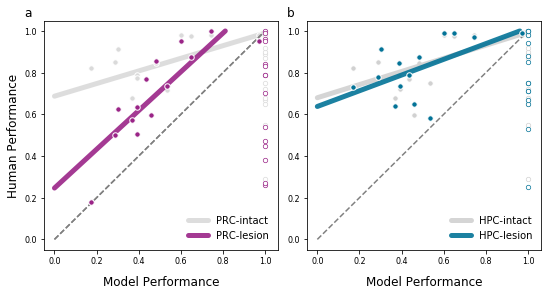

In [25]:
viz.retrospective_interaction(it_layer, retrospective, misclassified, figure_location) 

## 2.1.4 Available experiments do not enable focal claims about VVS dependence

In [26]:
lesion_set =  meta_statistics[[i in pls_fits['layers'] for i in meta_statistics['layer']]]

### Model layers that better fit IT cortex better predict PRC-related deficits

In [27]:
viz.show_model_parameters(smf.ols('zscore(lesion) ~ zscore(neural)', data={'lesion': lesion_set['prc_delta_rmse'],
                                                                           'neural': pls_fits['delta']}))

$\beta = 0.95$, $F(1, 17)$ = $13.20, P = 2 $ x $ 10 ^{-10} $

### Only "IT-like" model layers are significant after correcting for multiple comparisons 

In [28]:
# number of tests performed = n_layers 
n_layers = len(pls_fits['it']['mu'])
# original threshold
alpha_uncorrected = .05 
# correct for false positives with bonferroni correction
alpha_corrected = alpha_uncorrected/n_layers
# show layers that are significant after correcting for multiple comparisons with p value
lesion_set[lesion_set['prc_interaction'] < alpha_corrected][['layer', 'prc_interaction']]

,layer,prc_interaction
19,fc7,0.002572


### ... while there is not a significant interaction observed between HPC groups even at uncorrect thresholds 

In [29]:
lesion_set[lesion_set['hpc_interaction'] < alpha_uncorrected][['layer', 'prc_interaction']]

,layer,prc_interaction


### IT-like layers do not better predict V4-like layers

In [30]:
viz.show_model_parameters(smf.ols('prc_lesion ~ vvs_model + readout', {
                          'vvs_model': np.concatenate((retrospective[it_layer], retrospective[v4_layer])), 
                          'prc_lesion': np.concatenate((retrospective['prc_lesion'], retrospective['prc_lesion'])),
                          'readout': np.concatenate([np.repeat(0,n_experiments),np.repeat(1,n_experiments)])}))

$\beta = 0.05$, $F(2, 25)$ = $0.86, P = 0.400 $

## Figure 3

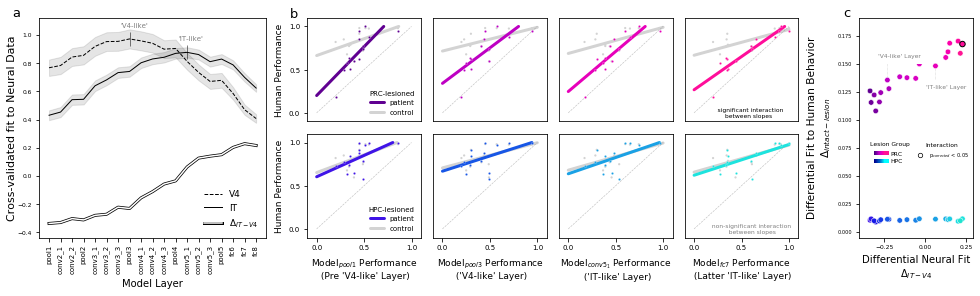

In [31]:
viz.focal_neuroanatomical_dependencies(pls_fits, retrospective, meta_statistics, figure_location)

## 2.2.1 High-throughput human psychophysics experiments

In [32]:
# human and model performance for all trials 
novel = pandas.read_csv(os.path.join(base_directory, 'high-throughput/human_performance.csv'))
# summary (for each object, averaged across all of its oddities) for human and model behavior 
novel_summary = pandas.read_csv(os.path.join(base_directory, 'high-throughput/summary_dataframe.csv'))

## 2.2.2 PRC-intact participants outperform electrophysiological recordings from IT

In [33]:
viz.show_model_parameters(smf.ols("delta ~ 1", {'delta':novel_summary['prc']-novel_summary['it']}))

$\beta = 0.24$, $F(0, 31)$ = $9.50, P = 1 $ x $ 10 ^{-10} $

### ... while IT outperforms V4

In [34]:
viz.show_model_parameters(smf.ols("delta ~ 1", {'delta':novel_summary['it']-novel_summary['v4']}))

$\beta = 0.18$, $F(0, 31)$ = $6.56, P = 2 $ x $ 10 ^{-7} $

### A computational proxy for IT cortex predicts a linear readout of electrophysiological recordings from IT

In [35]:
viz.show_model_parameters(smf.ols("it ~ fc6", novel_summary))

$\beta = 0.81$, $F(1, 30)$ = $13.33, P = 4 $ x $ 10 ^{-14} $

### ... while outperforming V4

In [36]:
viz.show_model_parameters(smf.ols("delta ~ 1", {'delta':novel_summary['fc6']-novel_summary['v4']}))

$\beta = 0.26$, $F(0, 31)$ = $8.02, P = 5 $ x $ 10 ^{-9} $

### ... and being outperformed by PRC-intact participants 

In [37]:
viz.show_model_parameters(smf.ols("delta ~ 1", {'delta':novel_summary['prc']-novel_summary['fc6']}))

$\beta = 0.16$, $F(0, 31)$ = $5.38, P = 7 $ x $ 10 ^{-6} $

### Reaction time is a reliable predictor of IT-supported performance

In [38]:
viz.show_model_parameters(smf.ols("zscore(it) ~ zscore(rt)", novel_summary))

$\beta = -0.88$, $F(1, 30)$ = $-10.00, P = 4 $ x $ 10 ^{-11} $

### The _difference_ between IT-supported and PRC-intact performance is predicted by reaction time

In [39]:
viz.show_model_parameters(smf.ols("zscore(delta_prc_it) ~ zscore(rt)", novel_summary))

$\beta = 0.81$, $F(1, 30)$ = $7.44, P = 3 $ x $ 10 ^{-8} $

### This relationship with reaction time is also observed in relation to model performance 

In [40]:
viz.show_model_parameters(smf.ols("zscore(delta) ~ zscore(rt)", 
                         {'delta':novel_summary['prc']-novel_summary['fc6'],'rt':novel_summary['rt']}))

$\beta = 0.72$, $F(1, 30)$ = $5.62, P = 4 $ x $ 10 ^{-6} $

### ... but not V4 supported performance

In [41]:
viz.show_model_parameters(smf.ols("zscore(delta_prc_v4) ~ zscore(rt)", novel_summary))

$\beta = -0.08$, $F(1, 30)$ = $-0.41, P = 0.682 $

# Figure 5 

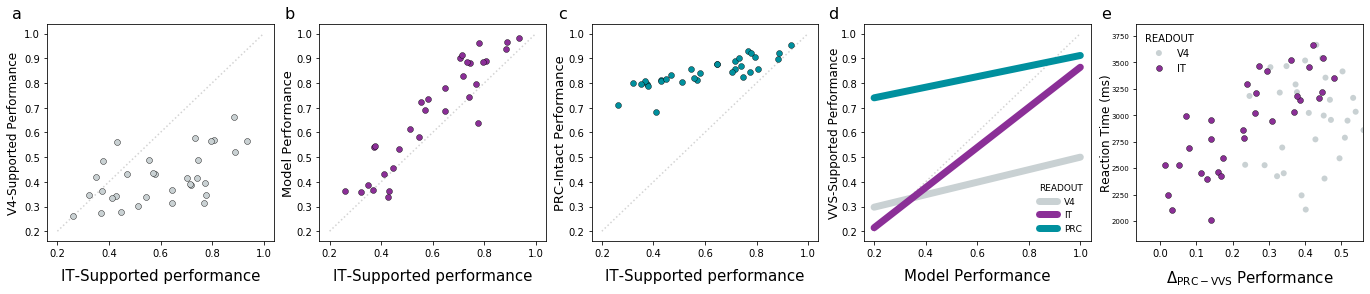

In [42]:
viz.high_throughput_results(novel_summary, figure_location)

# 2.3 In Silico Experiments

In [43]:
# path to in silico directory
in_silico = os.path.join(base_directory, 'in_silico')

# path to results from multiple architectures on retrospective experiments 
architectural_results = os.path.join(in_silico, 'architecture/retrospective.pickle')

# path to training results on retrospective stimuli 
training_results = os.path.join(in_silico, 'training/retrospective/facetrained_retrospective.pickle')

# path to multiple models training results on novel stimuli 
multiplemodels_results = os.path.join(in_silico, 'training/novel/multiple_models_novel_stimuli.csv')

## 2.3.1 Changing model architecture does not enable PRC-intact performance

In [44]:
with open(architectural_results, 'rb') as handle: 
    tmpnets = pickle.load(handle)
    resnets = pandas.DataFrame({i: [tmpnets[i][j] for j in retrospective['experiment']] for i in tmpnets})

### Deeper architectures do not better fit PRC-intact performance

In [45]:
# determined RMSE between model and prc-intact performance across all models
model_human_rmse = [(np.sqrt((resnets[i]-retrospective['prc_intact']).mean()**2)) for i in resnets]

# determine whether deeper models better fit (i.e. less RMSE) prc-intact performance 
viz.show_model_parameters(smf.ols('y ~ x-1', {'x': zscore(model_human_rmse),
                                              'y': zscore(np.arange(resnets.shape[1]))}))

$\beta = -0.55$, $F(1, 4)$ = $-1.33, P = 0.255 $

In [46]:
architecture = pandas.DataFrame()
for resnet in list(resnets): 
    for prc in ['prc_intact','prc_lesion']: 
        architecture = pandas.concat([architecture, pandas.DataFrame({'resnet':resnets[resnet], 
                                                                      'group':np.repeat(prc, len(resnets)),
                                                                      'human':retrospective[prc], 
                                                                      'layers': np.repeat(resnet, len(resnets))})])

### There is a significant interaction between PRC-intact and lesioned subjects across all architectures

In [47]:
viz.show_model_parameters(smf.ols('human ~ resnet * group', architecture[architecture.layers=='18']))

$\beta = 0.51$, $F(3, 24)$ = $3.32, P = 0.003 $

In [48]:
viz.show_model_parameters(smf.ols('human ~ resnet * group', architecture[architecture.layers=='34']))

$\beta = 0.45$, $F(3, 24)$ = $3.07, P = 0.005 $

In [49]:
viz.show_model_parameters(smf.ols('human ~ resnet * group', architecture[architecture.layers=='50']))

$\beta = 0.49$, $F(3, 24)$ = $3.25, P = 0.003 $

In [50]:
viz.show_model_parameters(smf.ols('human ~ resnet * group', architecture[architecture.layers=='101']))

$\beta = 0.56$, $F(3, 24)$ = $3.66, P = 0.001 $

In [51]:
viz.show_model_parameters(smf.ols('human ~ resnet * group', architecture[architecture.layers=='152']))

$\beta = 0.54$, $F(3, 24)$ = $3.97, P = 6 $ x $ 10 ^{-4} $

# Figure 6 

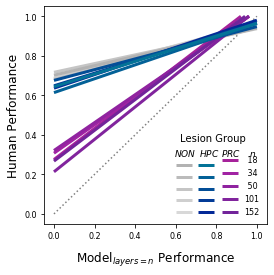

In [52]:
fig = plt.figure(figsize=[4, 4])
viz.show_resnets(retrospective.join(resnets), resnets.columns.values, figure_location)

## 2.3.2 Content-specific training enables VVS models to achieve PRC-intact accuracy

In [53]:
# load results from face-trained model 
with open(training_results, 'rb') as handle: 
    vggtraining_results = pickle.load(handle)

# integrate face-trained modeling results 
retrospective['vggface'] = [vggtraining_results[i] for i in retrospective.experiment.values]

# add marker to indicate whether experiment contains faces
retrospective['isface'] = ['face' in i for i in retrospective.experiment.values]

In [54]:
# load all results from multiple models
mm_all_markers = pandas.read_csv(multiplemodels_results)

# extract only the selected markers
mm_select = mm = mm_all_markers[[i in novel['marker'].values for i in mm_all_markers.trial_id]]

# identify modeling results for all models trained on imagenet
imagenet_novel = mm[(mm.model=='vgg16')*(mm.training_data=='imagenet')*(mm.image_type=='foveated')]

# integrate imagenet results on novel dataset with human behavior
novel['imagenet'] = [imagenet_novel[imagenet_novel.trial_id == i].accuracy.values[0] for i in novel['marker']]

# identify modeling results for all models trained on faces (vggface)
vggface_novel = mm[(mm.model=='vgg16')*(mm.training_data=='vggface')*(mm.image_type=='foveated')]

# integrate facetrained results on novel dataset with human behavior
novel['vggface'] = [vggface_novel[vggface_novel.trial_id == i].accuracy.values[0] for i in novel['marker']]

# average across all oddities for each object 
novel_summary = novel.groupby('typical_name').mean() 

###  For faces in the retrospective analysis, PRC-intact participants outperform PRC-lesioned participants

In [55]:
viz.show_model_parameters(smf.ols('d ~ 1', 
  {'d':retrospective[retrospective['isface']]['prc_intact']-retrospective[retrospective['isface']]['prc_lesion']}))

$\beta = 0.20$, $F(0, 3)$ = $4.25, P = 0.024 $

### ... as well as a computational proxy for the VVS

In [56]:
viz.show_model_parameters(smf.ols('d ~ 1',
        {'d':retrospective[retrospective['isface']]['prc_intact']-retrospective[retrospective['isface']]['fc6']}))

$\beta = 0.46$, $F(0, 3)$ = $8.47, P = 0.003 $

###  For faces in the novel analysis, PRC-intact participants outperform electrophysiological recordings from IT 

In [57]:
viz.show_model_parameters(smf.ols('delta ~ 1', {'delta':novel_summary['human']-novel_summary['it']}))

$\beta = 0.24$, $F(0, 31)$ = $9.50, P = 1 $ x $ 10 ^{-10} $

### ... as well as a computational proxy for the VVS

In [58]:
viz.show_model_parameters(smf.ols('d ~ 1',{'d':novel_summary['human']-novel_summary['imagenet']}))

$\beta = 0.20$, $F(0, 31)$ = $7.86, P = 7 $ x $ 10 ^{-9} $

### Training on faces leads to better model performance on faces in the retrospective analysis

In [59]:
viz.show_model_parameters(smf.ols('delta ~ 1', 
    {'delta':retrospective[retrospective['isface']]['vggface']-retrospective[retrospective['isface']]['fc6']}))

$\beta = 0.30$, $F(0, 3)$ = $4.75, P = 0.018 $

### ... and the novel dataset 

In [60]:
viz.show_model_parameters(smf.ols('d ~ 1', {'d':novel_summary['vggface']-novel_summary['imagenet']}))

$\beta = -0.03$, $F(0, 31)$ = $-0.75, P = 0.460 $

### Face-trained model performance indistinguishable from PRC-intact performance in the retrospective dataset

In [61]:
viz.show_model_parameters(smf.ols('d ~ 1',
    {'d':retrospective[retrospective['isface']]['prc_intact']-retrospective[retrospective['isface']]['vggface']}))

$\beta = 0.16$, $F(0, 3)$ = $1.91, P = 0.153 $

### ... and the novel dataset

In [62]:
viz.show_model_parameters(smf.ols('d ~ 1',{'d':novel_summary['human']-novel_summary['vggface']}))

$\beta = 0.24$, $F(0, 31)$ = $8.46, P = 1 $ x $ 10 ^{-9} $

### However, face-trained models perform worse on non-faces in the retrospective analysis

In [63]:
viz.show_model_parameters(smf.ols('d ~ 1', 
    {'d':retrospective[retrospective['isface']==0]['vggface'] - retrospective[retrospective['isface']==0]['fc6']}))

$\beta = -0.14$, $F(0, 9)$ = $-2.67, P = 0.026 $

### ... and the novel dataset

In [64]:
viz.show_model_parameters(smf.ols('d ~ 1',
    {'d':novel[novel.category!='faces']['vggface'] - novel[novel.category!='faces']['imagenet']}))

$\beta = -0.15$, $F(0, 136)$ = $-7.30, P = 2 $ x $ 10 ^{-11} $

### There is an interaction between training and testing performance in the retrospective dataset

In [65]:
viz.show_model_parameters(smf.ols( 'model ~ face *  type',
    {'human': np.array([retrospective['prc_lesion'], retrospective['prc_lesion']]).flatten(), 
     'model': np.array([retrospective['vggface'], retrospective['fc6']]).flatten(), 
     'face': np.array([retrospective.isface==False, retrospective.isface==False]).flatten(), 
     'type': np.array([np.repeat(0, len(retrospective)), np.repeat(1, len(retrospective))]).flatten()}))

$\beta = 0.44$, $F(3, 24)$ = $2.53, P = 0.018 $

### ... and the novel dataset

In [66]:
viz.show_model_parameters(smf.ols('model ~ face *  type', {
    'human': np.array([novel['human'], novel['human']]).flatten(), 
    'model': np.array([novel['vggface'], novel['imagenet']]).flatten(), 
    'face': np.array([novel.category=='faces', novel.category=='faces']).flatten(), 
    'type': np.array([np.repeat(0, len(novel)), np.repeat(1, len(novel))]).flatten()}))

$\beta = -0.48$, $F(3, 354)$ = $-8.99, P = 1 $ x $ 10 ^{-17} $

### Object-trained models demonstrate a correspondence with IT-supported performance

In [67]:
viz.show_model_parameters(smf.ols('zscore(it) ~ zscore(imagenet)', novel_summary))

$\beta = 0.86$, $F(1, 30)$ = $9.13, P = 4 $ x $ 10 ^{-10} $

### ... and human reaction time

In [68]:
viz.show_model_parameters(smf.ols('zscore(rt) ~ zscore(imagenet)', novel_summary))

$\beta = -0.80$, $F(1, 30)$ = $-7.39, P = 3 $ x $ 10 ^{-8} $

### There is no correspondence between IT-supported performance and face-trained models

In [69]:
viz.show_model_parameters(smf.ols('zscore(it) ~ zscore(vggface)', novel_summary))

$\beta = -0.08$, $F(1, 30)$ = $-0.42, P = 0.679 $

### No correspondence between reaction time and face-trained model

In [70]:
viz.show_model_parameters(smf.ols('zscore(rt) ~ zscore(vggface)', novel_summary))

$\beta = -0.16$, $F(1, 30)$ = $-0.88, P = 0.386 $

# Figure 7

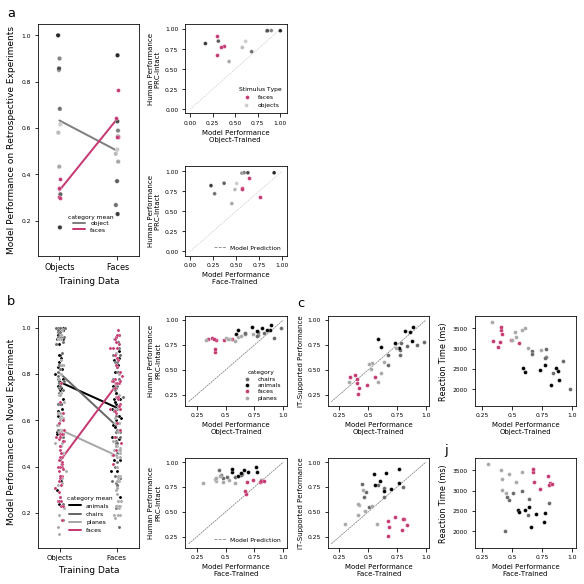

In [71]:
viz.changing_distribution_of_training_data(retrospective, mm_select, novel, figure_location)

# Supplemtary Figure S2

Visualize the results from misclassified stimulus sets in the retrospective analysis--model performance on all experiments is at ceiling 

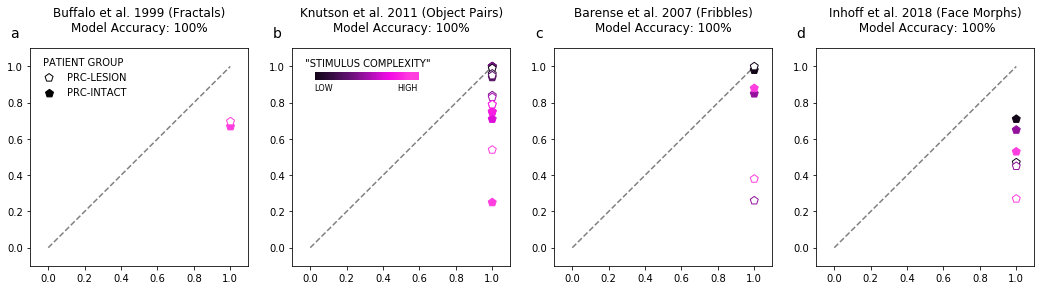

In [72]:
viz.show_misclassified_studies(misclassified, figure_location)

# Supplementary Figure S3

Using the known relationship between weighted and non-weighted (i.e. distance) readouts of model performance to correct for the nonweighted readout we used in the retrospective analyses

In [77]:
# location with original weighted and nonweighted (i.e. distance) model performance on novel stimuli 
unweighted_performance = os.path.join(electrophysiological_location, 'weighted_unweighted_model_performance.pickle')

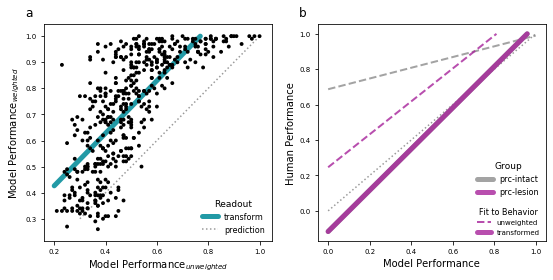

In [78]:
viz.transformed_model_performance(retrospective, unweighted_performance, figure_location)

# Supplementary Figure S4

Results from content-specific training without "foveating" images in the novel dataset prior to presenting to model

In [75]:
# identify modeling results for all models trained on imagenet presented with original images
imagenet_novel = mm[(mm.model=='vgg16')*(mm.training_data=='imagenet')*(mm.image_type=='original')]

# integrate facetrained results on novel dataset with human behavior
novel['imagenet_orig'] = [imagenet_novel[imagenet_novel.trial_id == i].accuracy.values[0] for i in novel['marker']]

# identify modeling results for all models trained on faces (vggface) presented with original images
vggface_novel = mm[(mm.model=='vgg16')*(mm.training_data=='vggface')*(mm.image_type=='original')]

# integrate facetrained results on novel dataset with human behavior
novel['vggface_orig'] = [vggface_novel[vggface_novel.trial_id == i].accuracy.values[0] for i in novel['marker']]

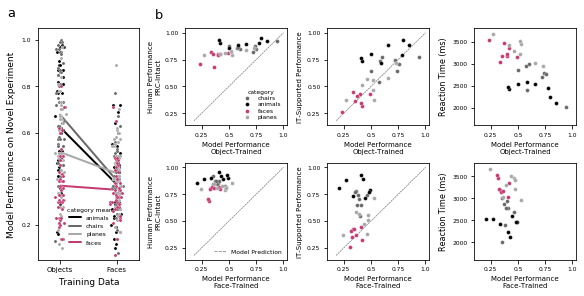

In [76]:
viz.unfoveated_model_behavior(retrospective, mm_select, novel, figure_location)